In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import phaseportrait as pp
from scipy.constants import convert_temperature as conv_temp

from controllers import ControllerBase
from controllers import PIDController
from controllers import PIDController_Tc
from controllers import LQRController_disc
from controllers import LQRController_cont
from classes import LEDparams, Model
from system import Simulation

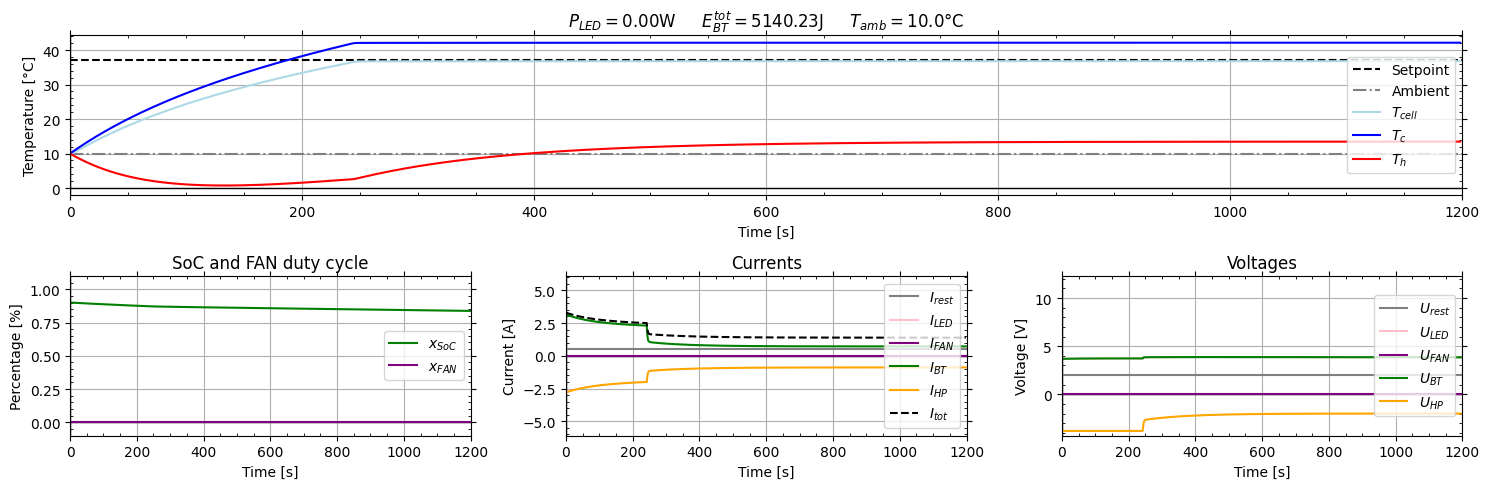

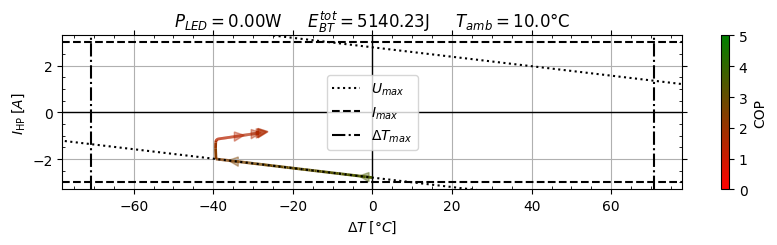

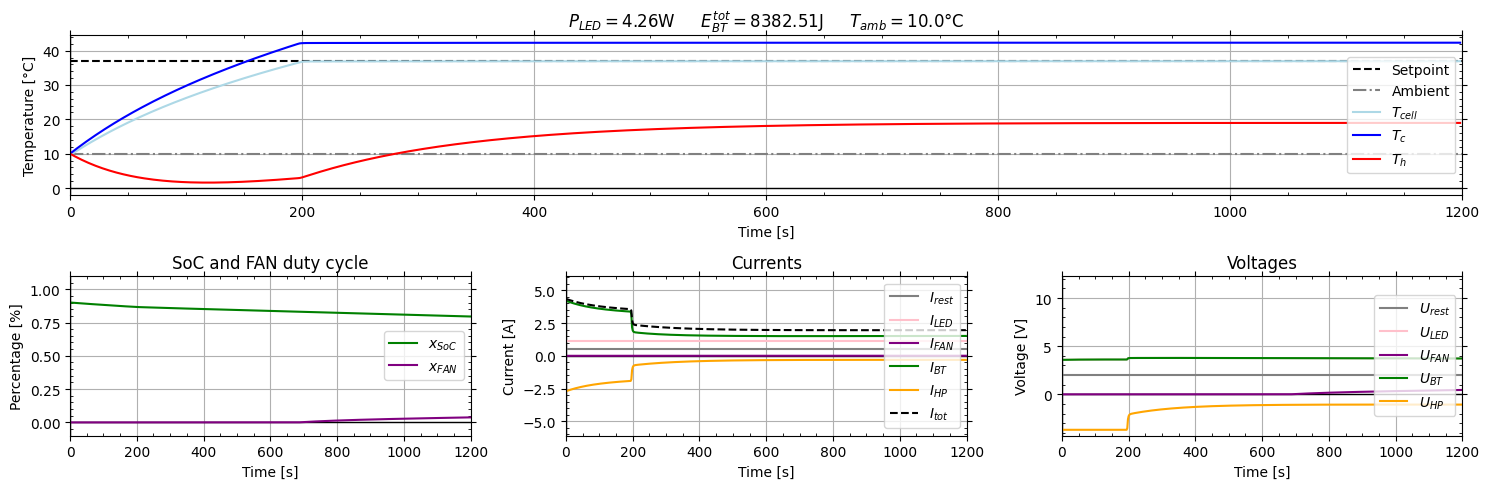

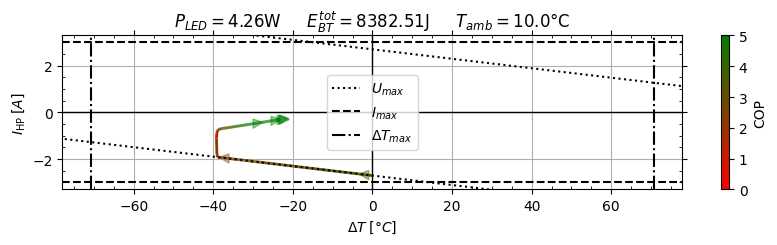

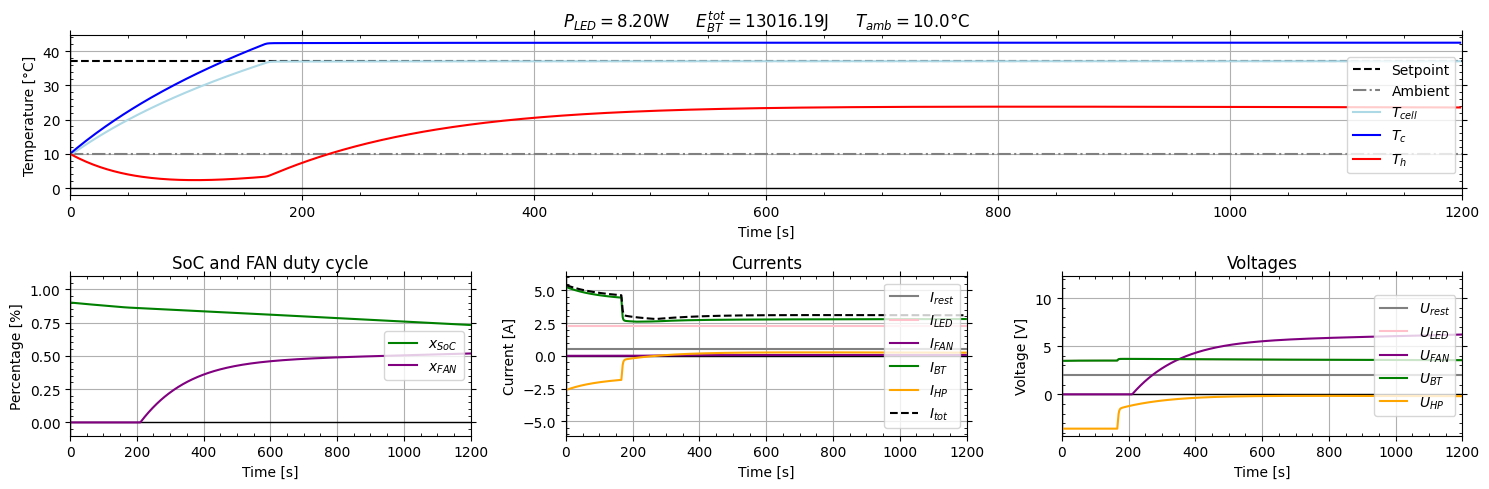

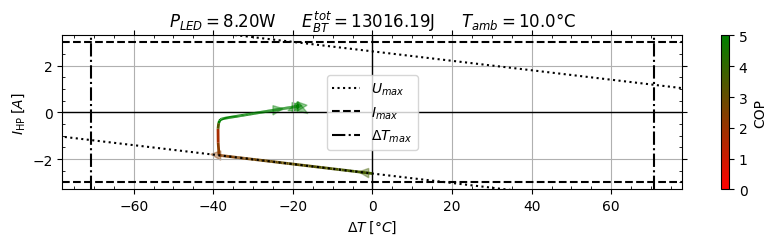

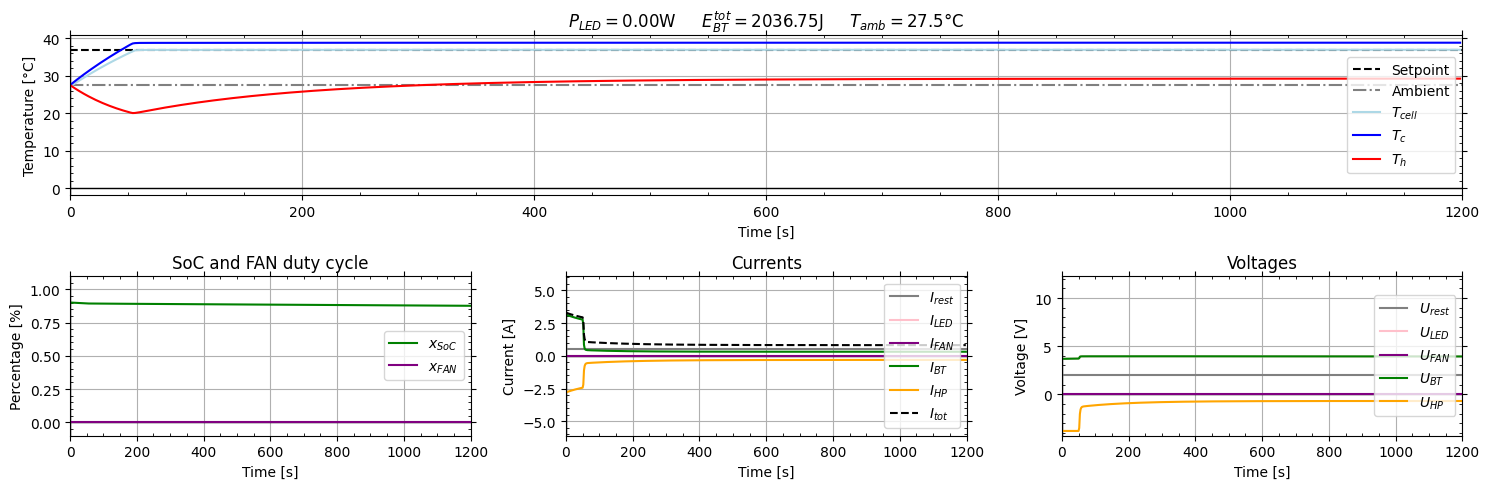

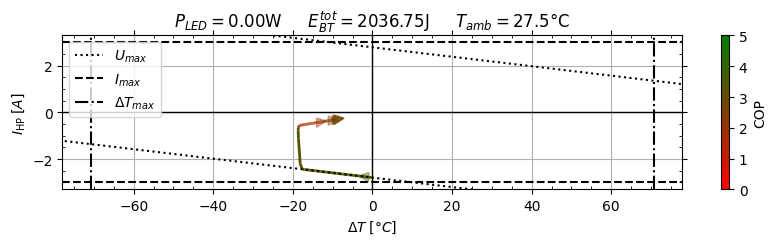

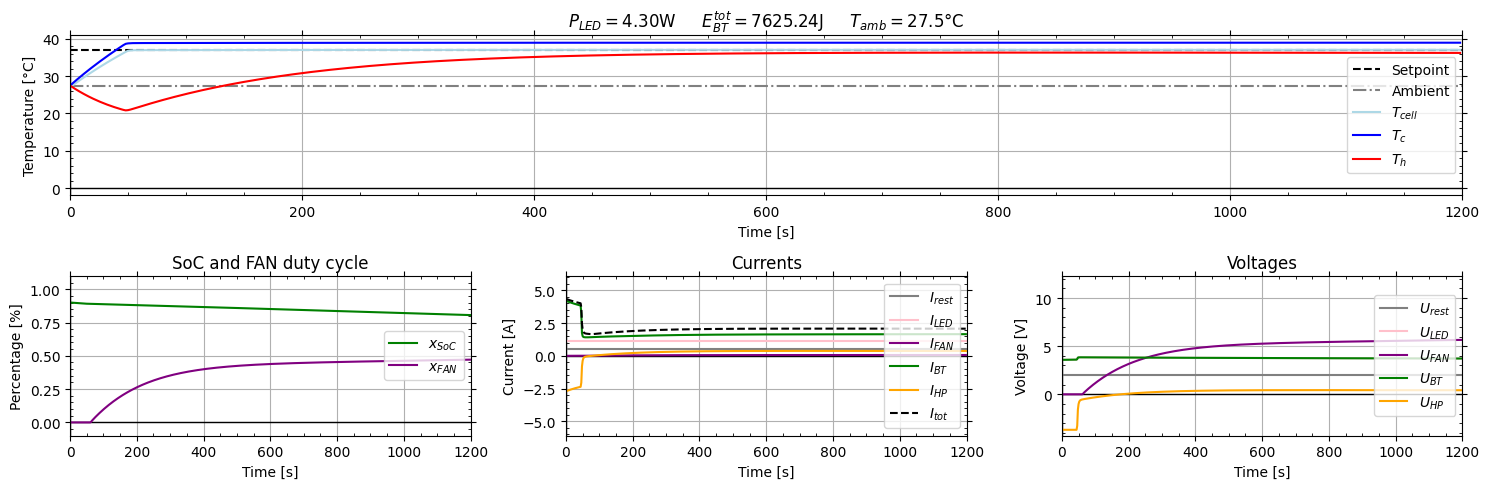

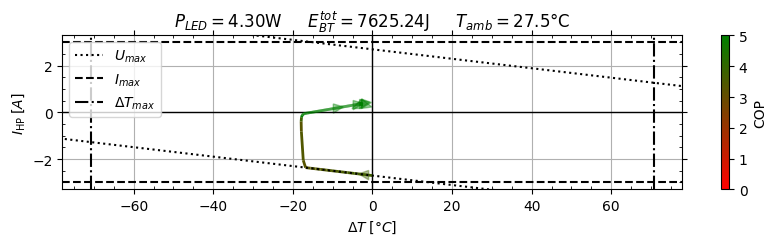

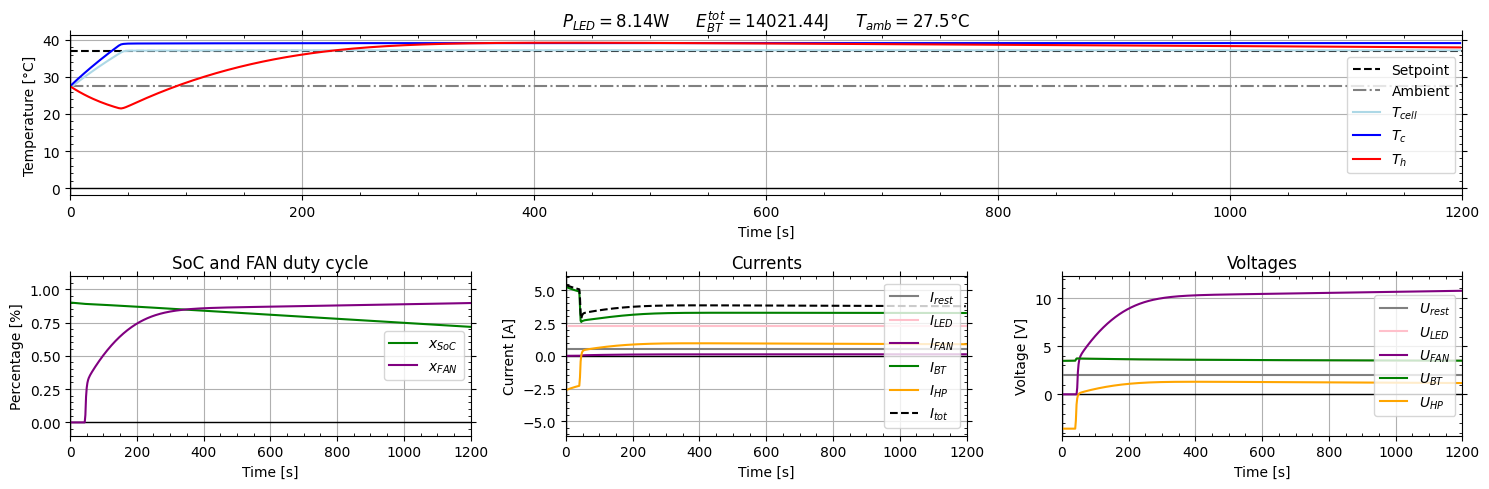

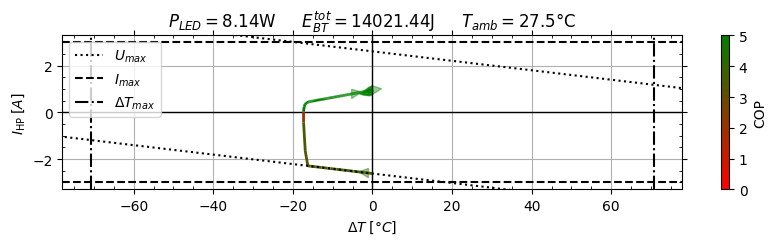

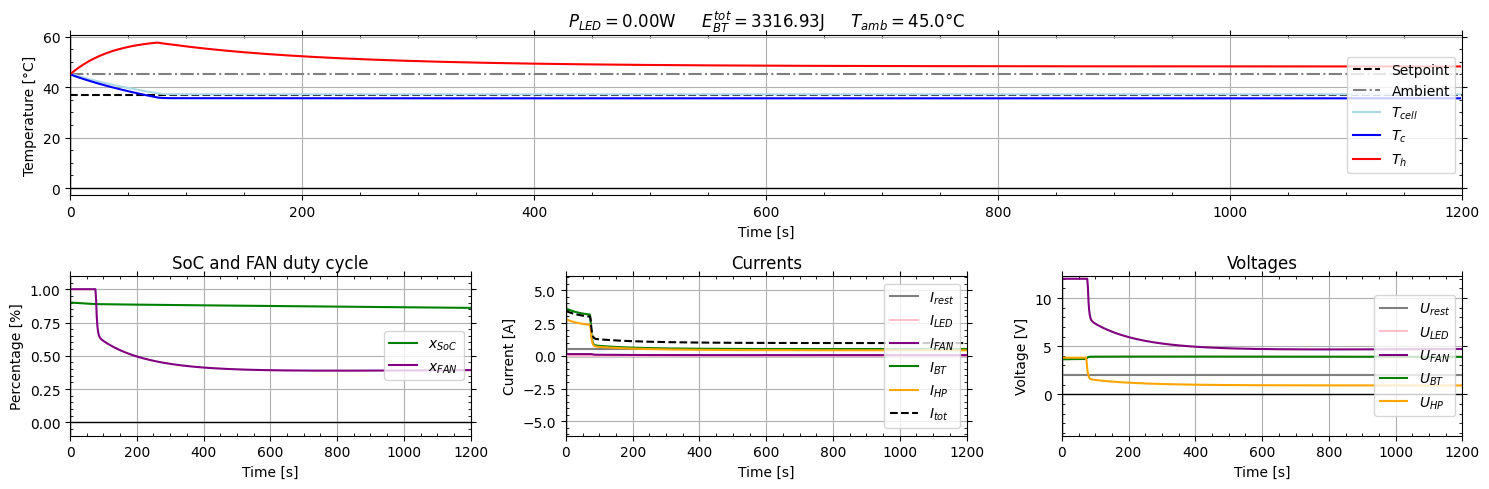

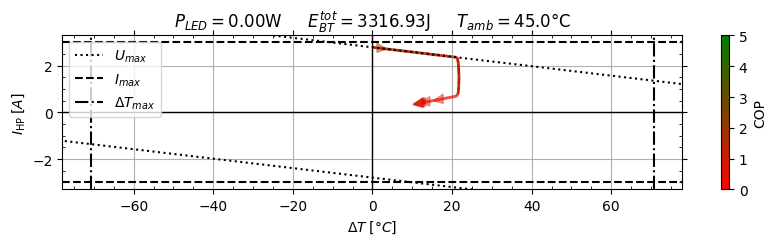

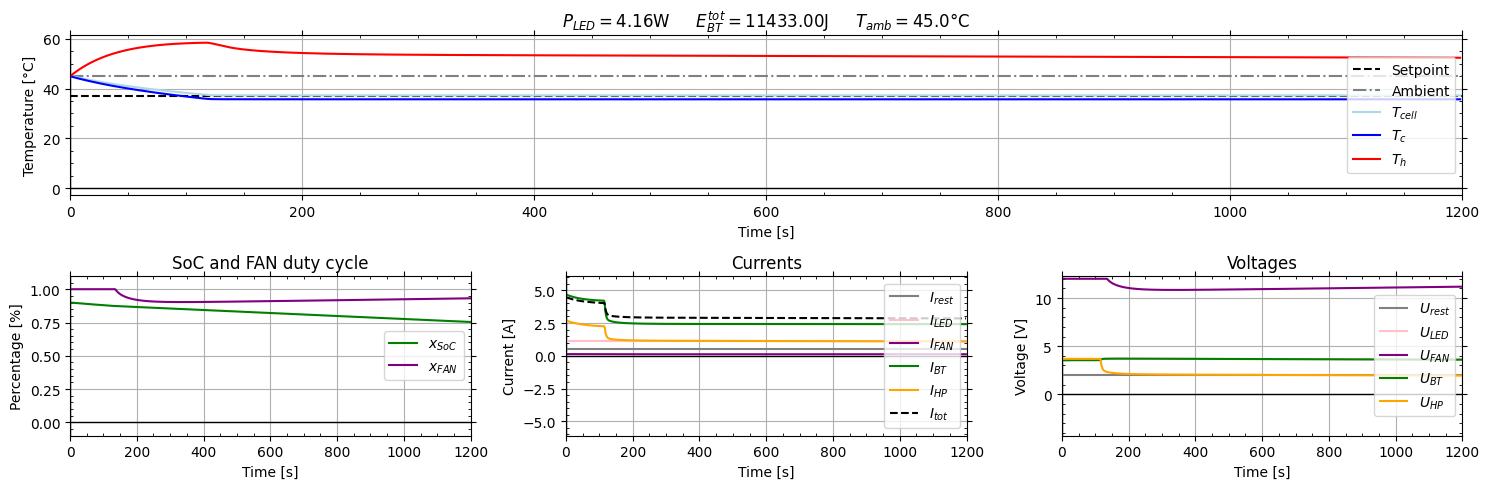

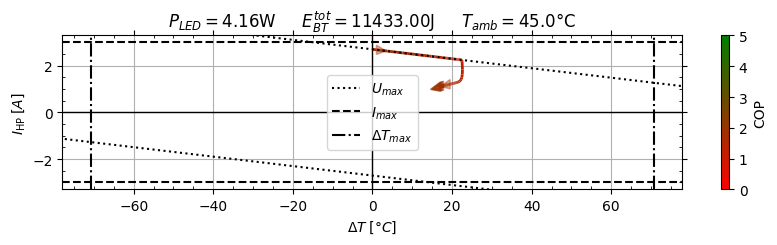

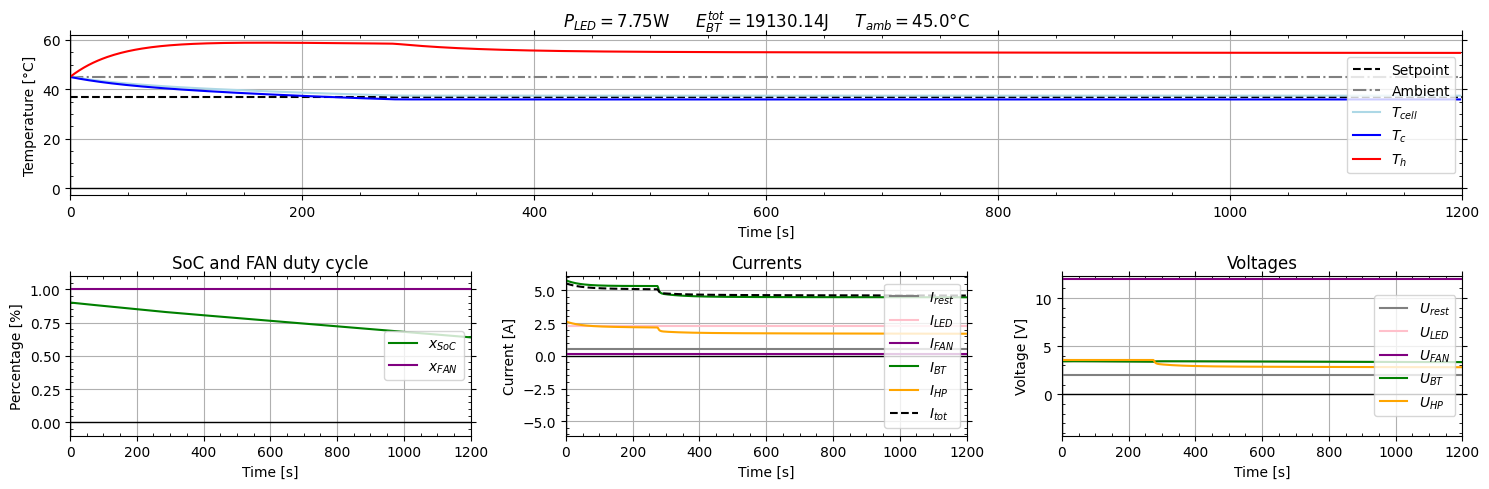

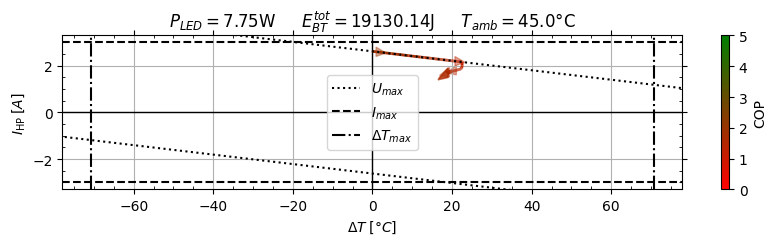

In [2]:
### Parameters
# Simulation
dt_sim = 2 # s
time_span = 60 * 20 # s

assert time_span > 0, "Time span must be positive."
assert time_span >= dt_sim, "Time span must be greater than or equal to the time step."

# LED
LEDpar = LEDparams()
dimensions = LEDpar.dimensions

# Controller
dt_disc = 0.0
setpoint_T_cell = conv_temp(37.0, 'C', 'K') # K


### Loop
## First iterable variable
num_traj_1 = 1

ratio_decrease = 5 # decrease power of the LED by 5 times compared to the maximum

x_matrix_max = np.ones(dimensions) * (2**16 - 1) # max value for 16 bit resolution

scale_factor = 1 / max(num_traj_1 - 1, 1)  # Avoid division by zero for 1 trajectory
x_matrix_norm_list = [x_matrix_max * traj * scale_factor / (2**16 - 1) / ratio_decrease 
                      for traj in range(num_traj_1)]  # from min of zeros to max of ones corrected by the ratio_decrease
# # TODO implement program reader
# x_matrix = np.random.randint(0, 2**16-1, dimensions)
# x_matrix_scaled = x_matrix / (2**16-1) # duty cycle


## Second iterable variable
num_traj_2 = 1
T_amb_list = conv_temp(np.linspace(10.0, 45.0, num=num_traj_2), 'C', 'K') # K
# T_amb = conv_temp(25.0, 'C', 'K') # K

## Start simulation loop
simulation_results = []
titles = []
for traj_2 in range(num_traj_2):
    for traj_1 in range(num_traj_1):
        # First iterable variable
        x_LED_tot, I_LED, P_r = LEDpar.program_reader(x_matrix_norm_list[traj_1])

        # Second iterable variable
        T_amb = T_amb_list[traj_2]

        # Initial conditions
        x0 = np.array([0.9, T_amb, T_amb])

        # Model
        model = Model(LEDpar, x0, T_amb0=T_amb)

        # PID
        kp, ki, kd = -2.5, -4.0, 0.0
        output_limits = (-model.I_HP_max, model.I_HP_max) # A

        pid_controller = PIDController(kp, ki, kd, setpoint_T_cell, dt_disc, output_limits)

        # R_frac = (model.R_4_lambda + model.R_5) / model.R_5
        # setpoint_Tc = (setpoint_T_cell - model.T_amb) * R_frac + model.T_amb
        # pid_controller_Tc = PIDController_Tc(kp, ki, kd, setpoint_T_cell, dt_disc, output_limits)

        # LQR
        A, B, h, C, D, l = model.get_continuous_linearization()
        q1 = 0
        q2 = 20 #/ (T_amb0**2)
        q3 = 0
        Q = np.array([[q1, 0, 0],
                    [0, q2, 0],
                    [0, 0, q3]])
        r1 = 10 / model.I_HP_max**2
        r2 = 1
        R = np.array([[r1, 0 ],
                    [0,  r2]])
        lqr_controller = LQRController_cont(model, setpoint_T_cell, A=A, B=B, Q=Q, R=R)

        # Save matrices as csv
        # directory = 'C:\\Users\\giaco\\Git_Repositories\\Semester_Thesis_1\\notebooks\\state_space\\' TODO CHANGE TO GENERAL
        # type = 'continuous'
        # model.save_linearized_model(directory, type)
        # type = 'discrete'
        # model.save_linearized_model(directory, type, Ts=dt_disc)

        # Simulation
        sim = Simulation(model=model, controller=lqr_controller, dt=dt_sim, time_span=time_span)

        # Run the simulation
        results = sim.run()
        results['id_traj_1'] = traj_1
        results['id_traj_2'] = traj_2
        simulation_results.append(results)

        # Plot
        P_LED = np.mean(results["U_BT"].to_numpy()) * I_LED * x_LED_tot # W
        title_P_LED = r"$P_{LED} =$" + f"{P_LED:.2f}W"

        E_BT_tot = np.trapezoid(results["U_BT"].to_numpy() * results["I_BT"].to_numpy(), results["time"].to_numpy()) # J
        title_E_BT = r"$E_{BT}^{tot} =$" + f"{E_BT_tot:.2f}J"

        title_T_amb = r"$T_{amb} =$" + f"{conv_temp(T_amb, 'K', 'C'):.1f}°C"

        title = title_P_LED + "     " + title_E_BT + "     " + title_T_amb

        titles.append(title_P_LED)

        sim.plot_time_results(title)
        sim.plot_current_temperature(title)

# All results
all_results_df = pd.concat(
    [df.assign(id_traj_1=i) for i, df in enumerate(simulation_results)]
).set_index(['id_traj_1', 'id_traj_2', 'time']) # MultiIndex


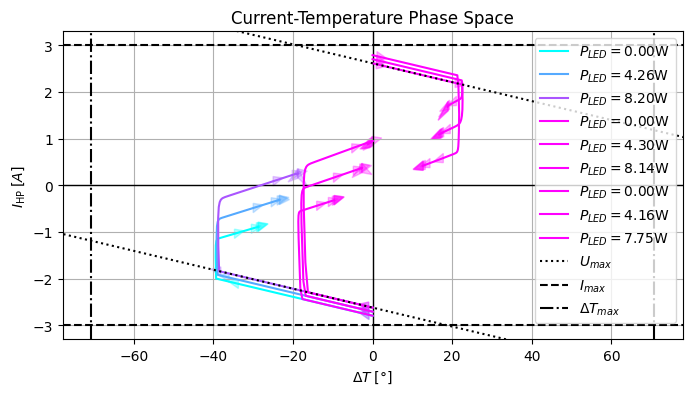

In [3]:
colormap = plt.colormaps['cool']
sim_len = sim.time_steps

## Arrows
# Steps and thresholds to sparse the arrows
arrow_step = 80
# threshold_dx = 1.0
# threshold_dy = 0.003

# def moving_average(data, window_size):
#     return np.convolve(data, np.ones(window_size) / window_size, mode='valid')
# # Remove noise
# window_size = 20
# smoothed_x_sim = moving_average(x_sim, window_size)
# smoothed_y_sim = moving_average(y_sim, window_size)

# dx = np.diff(smoothed_x_sim)
# dy = np.diff(smoothed_y_sim)

# # Mask to filter and get only transients
# arrow_mask = (np.abs(dx) > threshold_dx) | (np.abs(dy) > threshold_dy)
# arrow_mask = np.concatenate((np.zeros(window_size), arrow_mask))
# arrow_mask = np.cumsum(arrow_mask[::-1]) > 0
# arrow_mask = arrow_mask[::-1]

# arrow_x_vec = x_sim[arrow_mask]
# arrow_y_vec = y_sim[arrow_mask]

# arrow_dx_vec = dx[arrow_mask[window_size:]]
# arrow_dy_vec = dy[arrow_mask[window_size:]]

# arrow_x_vec = arrow_x_vec[::arrow_step]
# arrow_y_vec = arrow_y_vec[::arrow_step]
# arrow_dx_vec = arrow_dx_vec[::arrow_step]
# arrow_dy_vec = arrow_dy_vec[::arrow_step]

# Voltage constraints
x_vec = np.linspace(-100, 100, sim_len)
y_vec_min, y_vec_max = model.get_constraints_U_BT2I_HP(x_vec)

### Plot
plt.figure(figsize=(8, 4))
plt.axhline(y=0, lw=1, color='black', label='_nolegend_')
plt.axvline(x=0, lw=1, color='black', label='_nolegend_')
# Group by id_traj_1
for sim_id, group in all_results_df.groupby(level='id_traj_1'):
    # Compute x and y values for this trajectory
    x_sim = group["T_h"].to_numpy() - group["T_c"].to_numpy()
    y_sim = group["I_HP"].to_numpy()

    # Plot each trajectory
    traj_color = colormap(sim_id / num_traj_1)
    plt.plot(x_sim, y_sim, label=titles[sim_id], color=traj_color)
    for i in range(0, len(x_sim) - arrow_step, arrow_step):
        plt.arrow(
            x_sim[i], y_sim[i], 
            x_sim[i + 1] - x_sim[i], y_sim[i + 1] - y_sim[i], 
            head_width=0.2, head_length=2.5, fc=traj_color, ec=traj_color, alpha=0.3
        )

plt.plot(x_vec, y_vec_min, color='black', linestyle=':', label=r'$U_{max}$')
plt.plot(x_vec, y_vec_max, color='black', linestyle=':')
plt.axhline(y=model.I_HP_max, color='black', linestyle='--', label=r'$I_{max}$')
plt.axhline(y=-model.I_HP_max, color='black', linestyle='--')
plt.axvline(x=model.DeltaT_max, color='black', linestyle='-.', label=r'$\Delta T_{max}$')
plt.axvline(x=-model.DeltaT_max, color='black', linestyle='-.')

# Configure plot
plt.xlim(-model.DeltaT_max * 1.1, model.DeltaT_max * 1.1)
plt.ylim(-model.I_HP_max * 1.1, model.I_HP_max * 1.1)
plt.xlabel(r'$\Delta T \; [°]$')
plt.ylabel(r'$I_\mathrm{HP} \; [A]$')
plt.title('Current-Temperature Phase Space')
plt.legend()
plt.grid()
plt.show()

In [4]:
# # Continuous Open-Loop
# # Nonlinear phase portrait
# def f_nonlinear(Tc, Th):
#     u = model.get_operational_input
#     x = np.array([model.get_operational_state[0], Tc, Th])
#     x_ = model.dynamics_f(x, u)
#     return x_[1], x_[2]

# # Linear phase portrait
# def f_linear(Tc, Th):
#     u = model.get_operational_input
#     x = np.array([model.get_operational_state[0], Tc, Th])
#     x_ = A @ x + B @ u + h
#     return x_[1], x_[2]

# # Closed-Loop
# # Linear phase portrait
# def f_linear_cl(Tc, Th):
#     x = np.array([model.get_operational_state[0], Tc, Th])
#     x_ = (A - B @ lqr_controller.K) @ x + h
#     return x_[1], x_[2]

# # Plot
# # Nonlinear Phase Portrait
# pp_nonlinear_op = pp.PhasePortrait2D(f_nonlinear, [-50, 50], Title='Continuous Nonlinear Open-Loop', xlabel=r"$T_c$", ylabel=r"$T_h$")
# pp_nonlinear_op.plot()

# # Linear Phase Portrait
# pp_linear_op = pp.PhasePortrait2D(f_linear, [-50, 50], Title='Continuous Linear Open-Loop', xlabel=r"$T_c$", ylabel=r"$T_h$")
# pp_linear_op.plot()

# # Linear Phase Portrait closed-loop
# pp_linear_cl = pp.PhasePortrait2D(f_linear_cl, [100, 300], Title='Continuous Linear Closed-Loop', xlabel=r"$T_c$", ylabel=r"$T_h$")
# pp_linear_cl.plot()

In [5]:
# x_FAN = 1.0
# x_SoC = 0.85
# I_HP = 1.2

# lenght_data = 10

# # Define the system of equations dTh/dt = f3(Th, Tc) and dTc/dt = f2(Th, Tc)
# def f3(Th:np.ndarray, Tc:np.ndarray) -> np.ndarray:
#     tmp = np.zeros_like(Th)

#     for i in range(lenght_data):
#         tmp[i] = model.f_num(np.array([x_SoC, Tc[i], Th[i]]), np.array([I_HP, x_FAN]))[2]

#     return tmp

# def f2(Th:np.ndarray, Tc:np.ndarray) -> np.ndarray:
#     tmp = np.zeros_like(Th)

#     for i in range(lenght_data):
#         tmp[i] = model.f_num(np.array([x_SoC, Tc[i], Th[i]]), np.array([I_HP, x_FAN]))[1]

#     return tmp

# Th_sim = results["T_h"].to_numpy()
# Tc_sim = results["T_c"].to_numpy()

# # Create a grid of points in the (x, y) plane
# x = np.linspace(Th_sim.min()-abs(Th_sim.min())*0.1, Th_sim.max()+abs(Th_sim.max())*0.1, lenght_data)
# y = np.linspace(Tc_sim.min()-abs(Tc_sim.min())*0.1, Tc_sim.max()+abs(Tc_sim.max())*0.1, lenght_data)
# X, Y = np.meshgrid(x, y)

# # Compute the vector field at each grid point
# u = f3(x, y)
# v = f2(x, y)
# U, V = np.meshgrid(u, v)

# # Plot the streamlines using the quiver function
# plt.figure(figsize=(10, 3))
# plt.quiver(X, Y, U, V, color='g')  # Arrows indicating the direction field
# plt.plot(Th_sim, Tc_sim, color='r')
# plt.plot(conv_temp(T_amb0, 'K', 'C'), conv_temp(T_amb0, 'K', 'C'), 'o', color='black', label='Ambient')
# plt.xlabel(r"$T_\mathrm{h} \; [°]$")
# plt.ylabel(r"$T_\mathrm{c} \; [°]$")
# plt.title('Temperature Phase Portrait')

# # Additionally, plot using streamplot for smoother visualization
# plt.streamplot(X, Y, U, V, color='b', linewidth=1)

# plt.grid()
# plt.show()